In [1]:
# === Notebook 02 : Exploration & Analyses ===
# Cellule 1 : Import des données préparées

import pandas as pd
import matplotlib.pyplot as plt
import os

# Répertoire des outputs
OUT_DIR_CLEAN = "outputs/clean"

# Charger le fichier global communes_all
communes_all_path = os.path.join(OUT_DIR_CLEAN, "communes_all.csv")
communes_all = pd.read_csv(communes_all_path)

print("✅ communes_all chargé :", communes_all.shape[0], "lignes et", communes_all.shape[1], "colonnes")
print("\nAperçu :")
display(communes_all.head())

# Vérification rapide des colonnes attendues (version avec moyennes)
expected_cols = ["DEP", "INSEE_C", "nb_ventes", "prix_m2_moy", "loyer_m2_moy", "rentabilite_m2_moy"]
missing = [c for c in expected_cols if c not in communes_all.columns]
if missing:
    print("⚠️ Colonnes manquantes :", missing)
else:
    print("✅ Toutes les colonnes attendues sont présentes :", expected_cols)

# Vérifier les stats de base
print("\nStatistiques descriptives principales :")
display(communes_all.describe())


✅ communes_all chargé : 8426 lignes et 6 colonnes

Aperçu :


,DEP,INSEE_C,nb_ventes,prix_m2_moy,loyer_m2_moy,rentabilite_m2_moy
0,11,11001,63,1173.2318,9.236553,11.571651
1,11,11002,33,1582.4867,9.532426,8.664107
2,11,11003,29,1021.2512,8.474989,12.161631
3,11,11004,43,1644.3351,7.992160,7.557476
4,11,11005,134,1712.3025,8.824945,6.903784


✅ Toutes les colonnes attendues sont présentes : ['DEP', 'INSEE_C', 'nb_ventes', 'prix_m2_moy', 'loyer_m2_moy', 'rentabilite_m2_moy']

Statistiques descriptives principales :


,DEP,INSEE_C,nb_ventes,prix_m2_moy,loyer_m2_moy,rentabilite_m2_moy
count,8426.000000,8426.000000,8426.000000,8426.000000,8426.000000,8426.000000
mean,41.426062,41633.376573,215.020769,1637.146770,9.035386,8.579450
std,23.237370,23218.606506,1528.572939,654.640730,1.337698,1.784497
min,11.000000,11001.000000,1.000000,548.076900,6.407329,0.894154
25%,24.000000,24034.250000,22.000000,1282.483925,8.139324,7.373265
50%,33.000000,33244.500000,48.000000,1509.291850,8.775901,8.506639
75%,64.000000,64366.750000,119.000000,1818.956050,9.688368,9.703257
max,87.000000,87206.000000,93807.000000,28087.926000,17.313202,19.662493


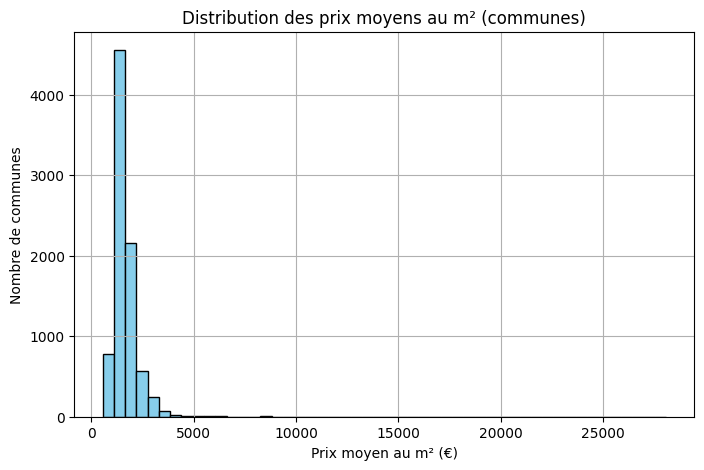

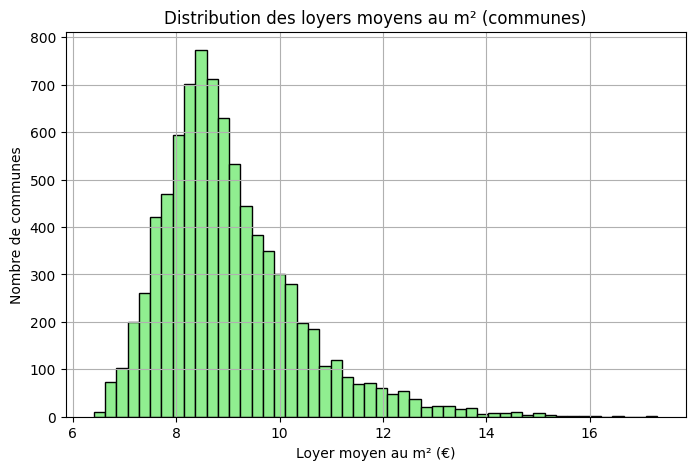

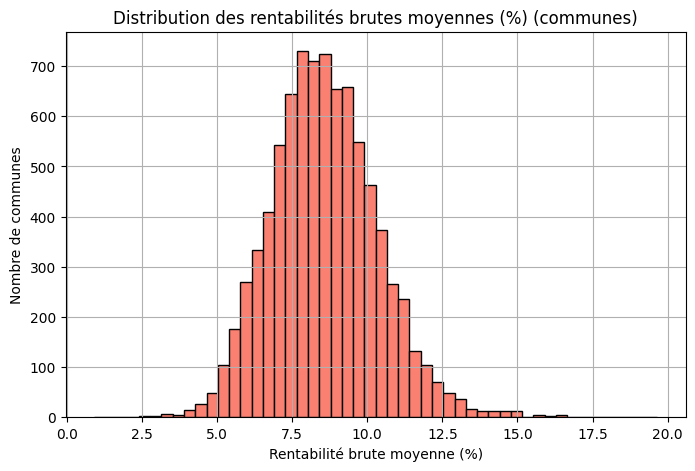

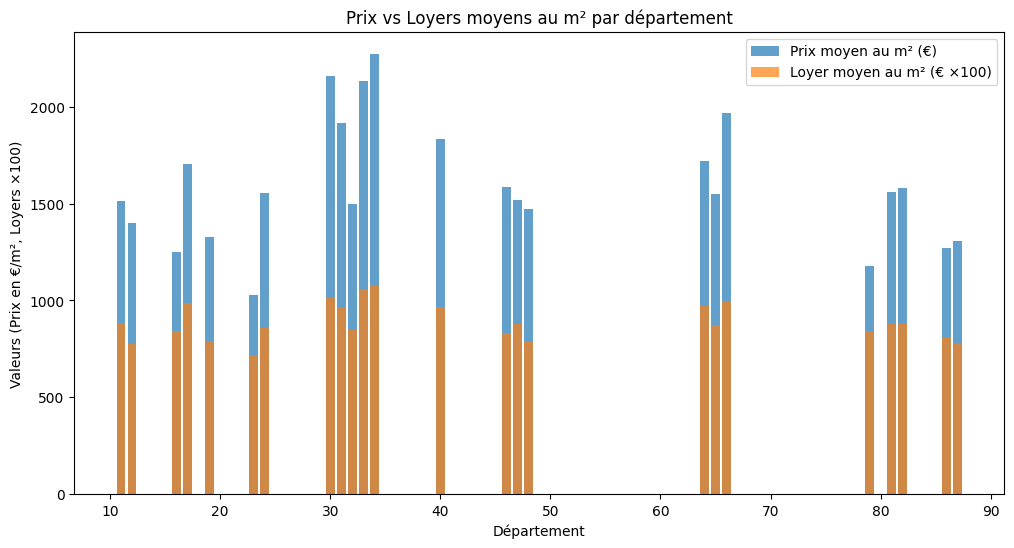

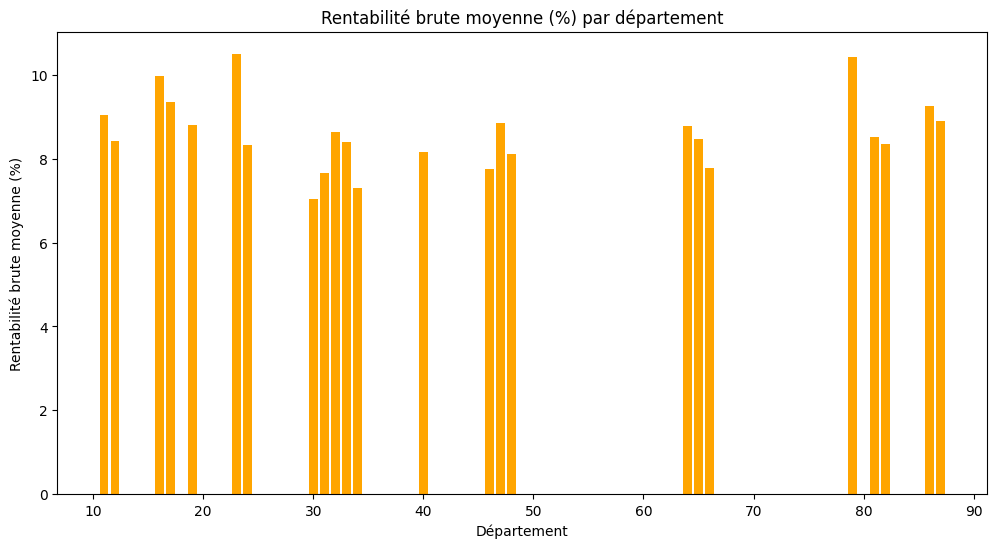

In [2]:
# === Cellule 2 : Visualisations globales ===

import matplotlib.pyplot as plt

# Histogramme des prix au m² (moyenne)
plt.figure(figsize=(8,5))
communes_all["prix_m2_moy"].hist(bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution des prix moyens au m² (communes)")
plt.xlabel("Prix moyen au m² (€)")
plt.ylabel("Nombre de communes")
plt.show()

# Histogramme des loyers au m² (moyenne)
plt.figure(figsize=(8,5))
communes_all["loyer_m2_moy"].hist(bins=50, color="lightgreen", edgecolor="black")
plt.title("Distribution des loyers moyens au m² (communes)")
plt.xlabel("Loyer moyen au m² (€)")
plt.ylabel("Nombre de communes")
plt.show()

# Histogramme des rentabilités (moyennes)
plt.figure(figsize=(8,5))
communes_all["rentabilite_m2_moy"].hist(bins=50, color="salmon", edgecolor="black")
plt.title("Distribution des rentabilités brutes moyennes (%) (communes)")
plt.xlabel("Rentabilité brute moyenne (%)")
plt.ylabel("Nombre de communes")
plt.show()

# Comparaison prix vs loyers par département (moyennes)
dep_stats = communes_all.groupby("DEP").agg(
    prix_m2_moy=("prix_m2_moy", "mean"),
    loyer_m2_moy=("loyer_m2_moy", "mean"),
    rentabilite_m2_moy=("rentabilite_m2_moy", "mean")
).reset_index()

plt.figure(figsize=(12,6))
plt.bar(dep_stats["DEP"], dep_stats["prix_m2_moy"], label="Prix moyen au m² (€)", alpha=0.7)
plt.bar(dep_stats["DEP"], dep_stats["loyer_m2_moy"]*100, label="Loyer moyen au m² (€ ×100)", alpha=0.7)
plt.title("Prix vs Loyers moyens au m² par département")
plt.xlabel("Département")
plt.ylabel("Valeurs (Prix en €/m², Loyers ×100)")
plt.legend()
plt.show()

# Rentabilité moyenne par département
plt.figure(figsize=(12,6))
plt.bar(dep_stats["DEP"], dep_stats["rentabilite_m2_moy"], color="orange")
plt.title("Rentabilité brute moyenne (%) par département")
plt.xlabel("Département")
plt.ylabel("Rentabilité brute moyenne (%)")
plt.show()


In [9]:
# === Cellule 3 : Top et Flop communes en rentabilité (avec noms) ===

# Charger le fichier loyers (déjà utilisé dans 01_preparation_donnees)
loyers_path = "Loyer/loyers_filtre_occitanie_nouvelle_aquitaine.csv"
loyers = pd.read_csv(loyers_path, sep=";", encoding="utf-8")

# Nettoyage rapide de la colonne loyer si besoin (comme dans notebook 01)
if loyers["loypredm2"].dtype == "object":
    loyers["loypredm2"] = (
        loyers["loypredm2"]
        .str.replace(",", ".", regex=False)
        .str.replace(" ", "", regex=False)
        .astype(float)
    )

# Fusion communes_all avec loyers pour récupérer le nom (LIBGEO)
communes_named = communes_all.merge(
    loyers[["INSEE_C", "LIBGEO"]],
    on="INSEE_C",
    how="left"
)

# Supprimer les doublons éventuels (au cas où plusieurs LIBGEO par code)
communes_named = communes_named.drop_duplicates(subset=["DEP", "INSEE_C"])

# Supprimer les communes avec valeurs manquantes
df_valid = communes_named.dropna(
    subset=["rentabilite_m2_moy", "prix_m2_moy", "loyer_m2_moy"]
)

# --- Top 10 global ---
top10 = df_valid.sort_values("rentabilite_m2_moy", ascending=False).head(10)
print("🔝 Top 10 communes par rentabilité brute moyenne (%)")
display(top10[["DEP", "INSEE_C", "LIBGEO",
               "rentabilite_m2_moy", "prix_m2_moy", "loyer_m2_moy", "nb_ventes"]])

# --- Flop 10 global ---
flop10 = df_valid.sort_values("rentabilite_m2_moy", ascending=True).head(10)
print("⚠️ Flop 10 communes par rentabilité brute moyenne (%)")
display(flop10[["DEP", "INSEE_C", "LIBGEO",
                "rentabilite_m2_moy", "prix_m2_moy", "loyer_m2_moy", "nb_ventes"]])

# --- Top 10 avec nb_ventes > 10 ---
df_valid_filtered = df_valid[df_valid["nb_ventes"] > 100]
top10_filtered = df_valid_filtered.sort_values("rentabilite_m2_moy", ascending=False).head(10)
print("🔝 Top 10 communes par rentabilité brute moyenne (%) (filtré : nb_ventes > 100)")
display(top10_filtered[["DEP", "INSEE_C", "LIBGEO",
                        "rentabilite_m2_moy", "prix_m2_moy", "loyer_m2_moy", "nb_ventes"]])


🔝 Top 10 communes par rentabilité brute moyenne (%)


,DEP,INSEE_C,LIBGEO,rentabilite_m2_moy,prix_m2_moy,loyer_m2_moy,nb_ventes
4760,17,17116,Consac,19.662493,1062.86460,9.255109,12
26080,65,65013,Ansost,18.245216,548.07690,8.333152,1
27500,65,65381,Sabarros,18.046183,770.63200,7.587695,3
628,11,11160,Galinagues,17.598822,1375.55740,9.300686,13
6832,19,19168,Pradines,17.316723,591.62370,7.485338,4
904,11,11230,Mérial,16.778889,752.65125,9.294004,5
25920,64,64531,Tabaille-Usquain,16.614138,927.06866,9.935357,7
7520,23,23059,La Chaussade,16.585426,577.50000,6.849565,2
25448,64,64412,Nabas,16.558410,866.18567,8.959445,10
4504,17,17049,Blanzay-sur-Boutonne,16.536062,885.14410,9.517236,12


⚠️ Flop 10 communes par rentabilité brute moyenne (%)


,DEP,INSEE_C,LIBGEO,rentabilite_m2_moy,prix_m2_moy,loyer_m2_moy,nb_ventes
20348,40,40242,Rimbez-et-Baudiets,0.894154,11992.6200,8.936037,1
5408,17,17286,Les Portes-en-Ré,2.646175,7271.0996,12.529368,402
16816,33,33236,Lège-Cap-Ferret,2.734483,9978.2270,13.211596,2647
4512,17,17051,Le Bois-Plage-en-Ré,2.861798,6686.7840,12.529367,716
5732,17,17369,Saint-Martin-de-Ré,2.883278,6158.1350,12.529368,621
5452,17,17297,Rivedoux-Plage,3.165480,5752.8910,12.529368,538
4932,17,17161,La Flotte,3.175084,6068.2700,12.529368,783
4780,17,17121,La Couarde-sur-Mer,3.223100,5884.2617,12.529368,482
968,11,11247,Monthaut,3.255263,3420.2646,8.298773,2
5700,17,17360,Sainte-Marie-de-Ré,3.264702,5509.1960,12.529367,853


🔝 Top 10 communes par rentabilité brute moyenne (%) (filtré : nb_ventes > 100)


,DEP,INSEE_C,LIBGEO,rentabilite_m2_moy,prix_m2_moy,loyer_m2_moy,nb_ventes
17448,33,33402,Sainte-Foy-la-Grande,13.343766,946.99805,8.596535,289
7224,19,19272,Tulle,12.723861,994.65120,8.746646,1390
10464,30,30037,Bessèges,12.658935,1294.24840,8.537541,274
17120,33,33316,Pellegrue,12.549180,1337.98890,9.194404,123
31432,82,82089,Lamagistère,12.415714,1028.95400,8.540465,176
27556,65,65395,Saint-Pé-de-Bigorre,12.287578,1099.54540,9.147512,154
30264,81,81115,Labastide-Rouairoux,12.187792,1016.16790,8.567849,186
30448,81,81163,Mazamet,12.183833,1051.17000,8.701145,1342
15920,33,33006,Anglade,12.151538,1308.25320,10.503612,129
7320,23,23008,Aubusson,12.101391,910.07270,7.625773,256


C:\Users\Antoine\AppData\Local\Temp\ipykernel_18464\1195092623.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fusion_all = pd.concat(dfs, ignore_index=True)


✅ fusion_all chargé : (7247060, 14)
Colonnes temporelles disponibles : ['anneemut', 'moismut']


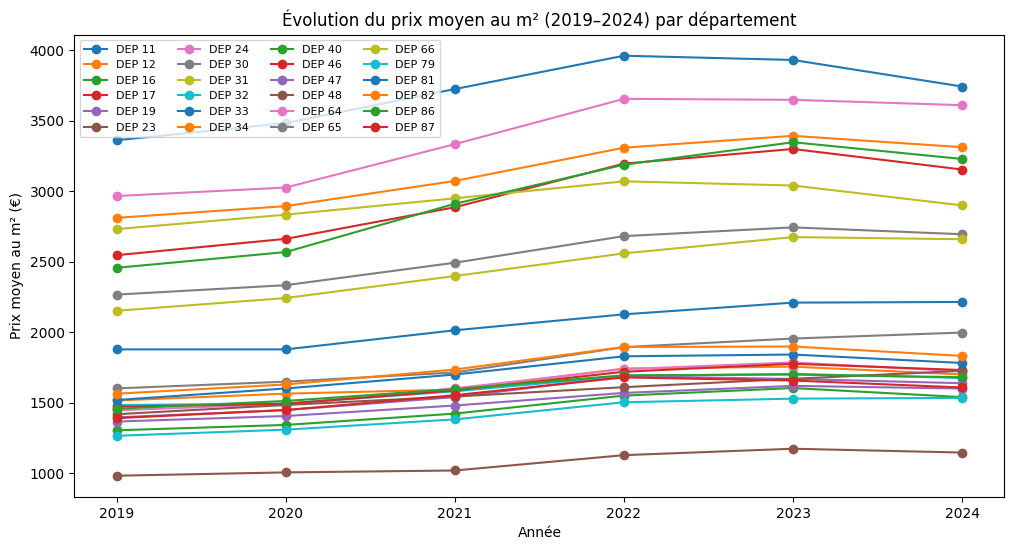

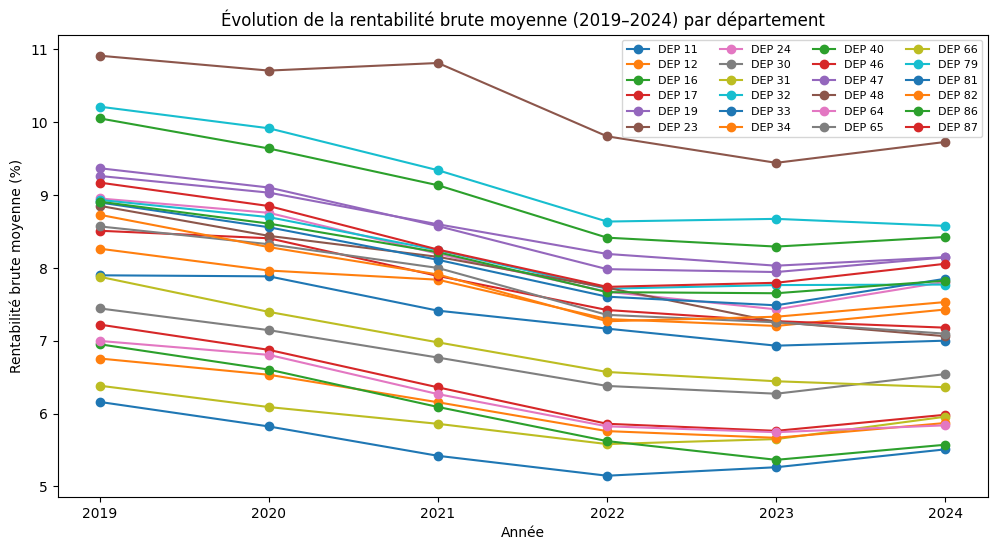

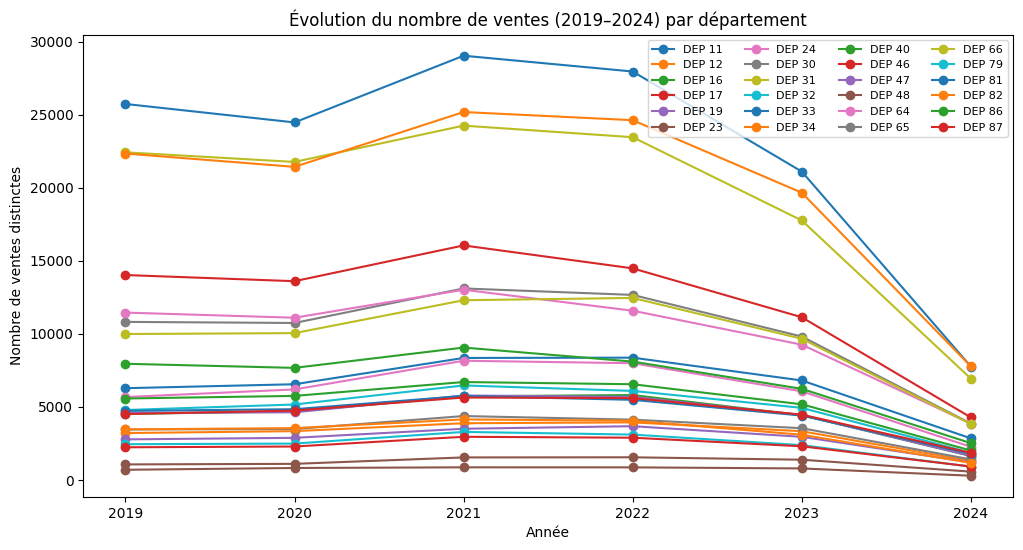

In [7]:
# === Cellule 4 : Evolution temporelle prix & rentabilités ===

import glob

# Charger tous les fichiers fusion_dep_XX.csv
fusion_files = glob.glob(os.path.join(OUT_DIR_CLEAN, "fusion_dep_*.csv"))

dfs = []
for f in fusion_files:
    df_tmp = pd.read_csv(f)
    dfs.append(df_tmp)

fusion_all = pd.concat(dfs, ignore_index=True)

print("✅ fusion_all chargé :", fusion_all.shape)

# Vérifier que les colonnes temps sont présentes
time_cols = [c for c in ["anneemut", "moismut", "datemut"] if c in fusion_all.columns]
print("Colonnes temporelles disponibles :", time_cols)

# On se limite à 2019–2024
fusion_all = fusion_all[(fusion_all["anneemut"] >= 2019) & (fusion_all["anneemut"] <= 2024)]

# Agrégation par année et département (moyennes)
evol = fusion_all.groupby(["DEP", "anneemut"], as_index=False).agg(
    prix_m2_moy=("prix_m2", "mean"),
    loyer_m2_moy=("loypredm2", "mean"),
    rentabilite_m2_moy=("rentabilite_m2", "mean"),
    nb_ventes=("idmutation", "nunique")  # nombre de ventes distinctes
)

# --- Visualisations ---
# Evolution du prix moyen au m² par département
plt.figure(figsize=(12,6))
for dep in evol["DEP"].unique():
    sub = evol[evol["DEP"] == dep]
    plt.plot(sub["anneemut"], sub["prix_m2_moy"], marker="o", label=f"DEP {dep}")
plt.title("Évolution du prix moyen au m² (2019–2024) par département")
plt.xlabel("Année")
plt.ylabel("Prix moyen au m² (€)")
plt.legend(ncol=4, fontsize=8)
plt.show()

# Evolution de la rentabilité brute moyenne par département
plt.figure(figsize=(12,6))
for dep in evol["DEP"].unique():
    sub = evol[evol["DEP"] == dep]
    plt.plot(sub["anneemut"], sub["rentabilite_m2_moy"], marker="o", label=f"DEP {dep}")
plt.title("Évolution de la rentabilité brute moyenne (2019–2024) par département")
plt.xlabel("Année")
plt.ylabel("Rentabilité brute moyenne (%)")
plt.legend(ncol=4, fontsize=8)
plt.show()

# Nombre de ventes par département
plt.figure(figsize=(12,6))
for dep in evol["DEP"].unique():
    sub = evol[evol["DEP"] == dep]
    plt.plot(sub["anneemut"], sub["nb_ventes"], marker="o", label=f"DEP {dep}")
plt.title("Évolution du nombre de ventes (2019–2024) par département")
plt.xlabel("Année")
plt.ylabel("Nombre de ventes distinctes")
plt.legend(ncol=4, fontsize=8)
plt.show()


In [8]:
import glob
import pandas as pd
import re

# Charger les fichiers fusion (ici DEP 23, ou tous si besoin)
fusion_files = glob.glob("outputs/clean/fusion_dep_23.csv")  # change en fusion_dep_*.csv pour tout
dfs = [pd.read_csv(f) for f in fusion_files if os.path.getsize(f) > 0]
fusion_all = pd.concat(dfs, ignore_index=True)

# Fonction pour extraire proprement un code INSEE à 5 chiffres
def extract_insee_codes(s):
    return re.findall(r"\b\d{5}\b", str(s))

# Normaliser : INSEE_C ou l_codinsee
if "l_codinsee" in fusion_all.columns:
    fusion_all["INSEE_norm"] = fusion_all["l_codinsee"].apply(extract_insee_codes).explode()
elif "INSEE_C" in fusion_all.columns:
    fusion_all["INSEE_norm"] = fusion_all["INSEE_C"].astype(str).str.zfill(5)  # sécurité padding
else:
    raise KeyError("Pas de colonne INSEE trouvée dans fusion_all")

# Filtrer pour un code INSEE précis
code_target = "23265"
subset = fusion_all[fusion_all["INSEE_norm"] == code_target].copy()

print(f"Nombre de lignes pour INSEE {code_target} :", len(subset))
display(subset.head(20))  # affiche juste 20 premières lignes pour pas saturer


Nombre de lignes pour INSEE 23265 : 0


,idmutation,INSEE_C,DEP,anneemut,moismut,prix_m2,valeurfonc,sbati,libtypbien,vefa,REG,LIBGEO,loypredm2,rentabilite_m2,INSEE_norm


In [10]:
# === Cellule X : Top 20 communes par nombre de ventes ===

# Charger fusion_all (toutes les transactions DVF enrichies)
import glob

fusion_files = glob.glob(os.path.join(OUT_DIR_CLEAN, "fusion_dep_*.csv"))
dfs = [pd.read_csv(f) for f in fusion_files]
fusion_all = pd.concat(dfs, ignore_index=True)

# Compter le nombre de ventes distinctes par code INSEE
ventes_par_commune = (
    fusion_all.groupby("INSEE_C")
    .agg(nb_ventes=("idmutation", "nunique"))  # nombre de mutations distinctes
    .reset_index()
    .sort_values("nb_ventes", ascending=False)
)

# Top 20
top20 = ventes_par_commune.head(20)
print("🔝 Top 20 communes avec le plus de ventes DVF")
display(top20)


C:\Users\Antoine\AppData\Local\Temp\ipykernel_18464\1643648310.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fusion_all = pd.concat(dfs, ignore_index=True)


🔝 Top 20 communes avec le plus de ventes DVF


,INSEE_C,nb_ventes
3476,31555,93807
4681,34172,53002
4036,33063,52962
2763,30189,21926
7105,66136,20325
1366,17300,17601
8312,87085,17593
6395,64445,16892
4512,34003,16178
4247,33281,13650


In [14]:
# === Cellule X corrigée : Top 20 communes intéressantes (rentabilité × fiabilité) ===
import numpy as np

# On part de communes_all (agrégées par commune)
df_valid = communes_all.dropna(subset=["rentabilite_m2_moy", "nb_ventes"])

# Construire un score combinant rentabilité et fiabilité
df_valid["score_interet"] = df_valid["rentabilite_m2_moy"] * np.log1p(df_valid["nb_ventes"])

# Fusion avec loyers pour ajouter le nom des communes
loyers_path = "Loyer/loyers_filtre_occitanie_nouvelle_aquitaine.csv"
loyers = pd.read_csv(loyers_path, sep=";", encoding="utf-8")

communes_named = df_valid.merge(loyers[["INSEE_C", "LIBGEO"]], on="INSEE_C", how="left")

# ⚡ Supprimer les doublons (on garde 1 ligne par DEP + INSEE_C)
communes_named = communes_named.drop_duplicates(subset=["DEP", "INSEE_C"])

# Top 20
top20_interessantes = communes_named.sort_values("score_interet", ascending=False).head(20)

print("🔝 Top 20 communes les plus intéressantes (bonne rentabilité × nombre de ventes)")
display(top20_interessantes[[
    "DEP", "INSEE_C", "LIBGEO",
    "rentabilite_m2_moy", "nb_ventes", "score_interet"
]])


🔝 Top 20 communes les plus intéressantes (bonne rentabilité × nombre de ventes)


,DEP,INSEE_C,LIBGEO,rentabilite_m2_moy,nb_ventes,score_interet
28420,66,66136,Perpignan,9.424446,20325,93.487264
7224,19,19272,Tulle,12.723861,1390,92.092484
33248,87,87085,Limoges,8.995930,17593,87.938033
30448,81,81163,Mazamet,12.183833,1342,87.756021
27732,65,65440,Tarbes,9.759357,6807,86.134652
2916,16,16015,Angoulême,9.606109,6658,84.569538
29360,79,79191,Niort,9.031596,10381,83.522654
268,11,11069,Carcassonne,9.490041,6628,83.504856
18164,34,34032,Béziers,8.777136,12820,83.021523
8436,24,24037,Bergerac,9.633956,4877,81.816281
